## Problem statement 

The objective of this assignment is to understand customer purchasing behaviour which will help in making better marketing strategies and thus eventually help in revenue increase (Read more about customer segmentation - https://www.coursera.org/articles/customer-segmentation)

The dataset is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

data source = https://archive.ics.uci.edu/dataset/352/online+retail

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from ydata_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

## Reading the data

In [2]:
%%time
raw_data = pd.read_excel("Online Retail.xlsx")

CPU times: total: 1min 12s
Wall time: 1min 37s


## Data definition
The dataset has 8 column with their definition from the data source listed below:-

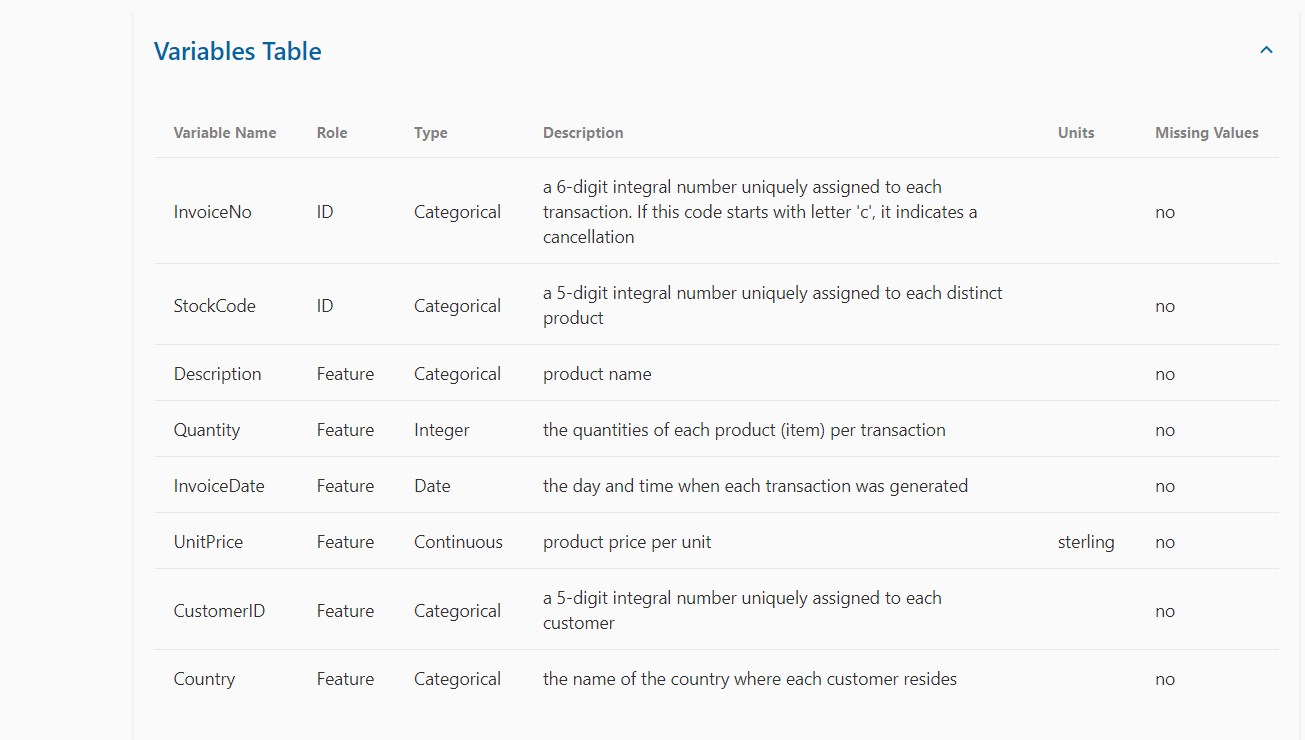

In [3]:
raw_data.Description = raw_data.Description.astype('string')
raw_data.InvoiceNo = raw_data.InvoiceNo.astype('string')
raw_data.StockCode = raw_data.StockCode.astype('string')

## EDA using ydata profiling
More info - https://docs.profiling.ydata.ai/latest/

In [4]:
profile = ProfileReport(raw_data, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### EDA results

1. <h3>Data statistics</h3>

   As per <b>dataset statistics</b>, there are <b>1%</b> duplicates rows and <b>3%</b> missing cells <br>
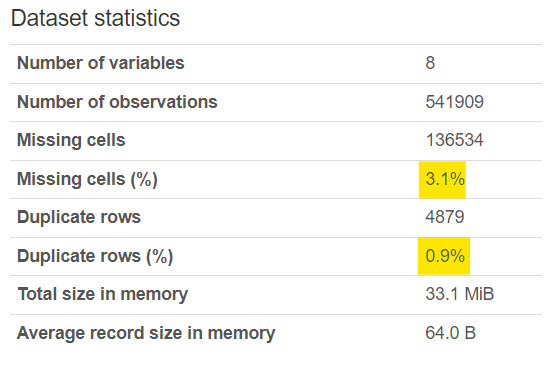<br>

2. <h3>Quantity</h3>

   Quantity refers to quantity of product per transaction <br>
   <b>2%</b> of quantities are negative, which represents cancellation <br>
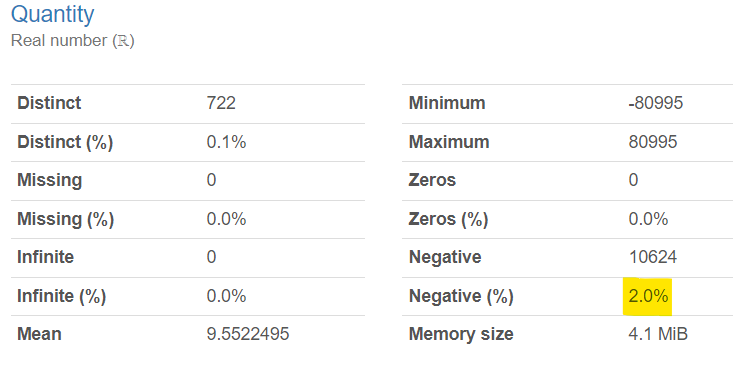 <br><br>
   common values of quantity is shown below <br>
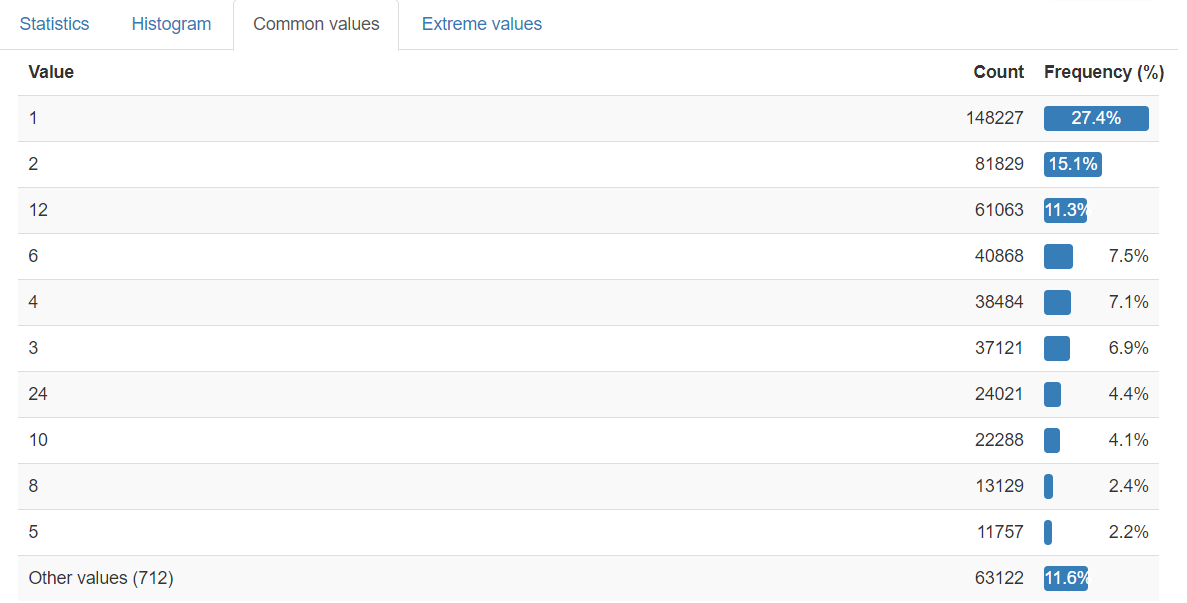<br>


3. <h3>InvoiceDate</h3>

   No missing invoice date <br>
   Slight increase in invoices in second half of the year suggests higher sales <br>
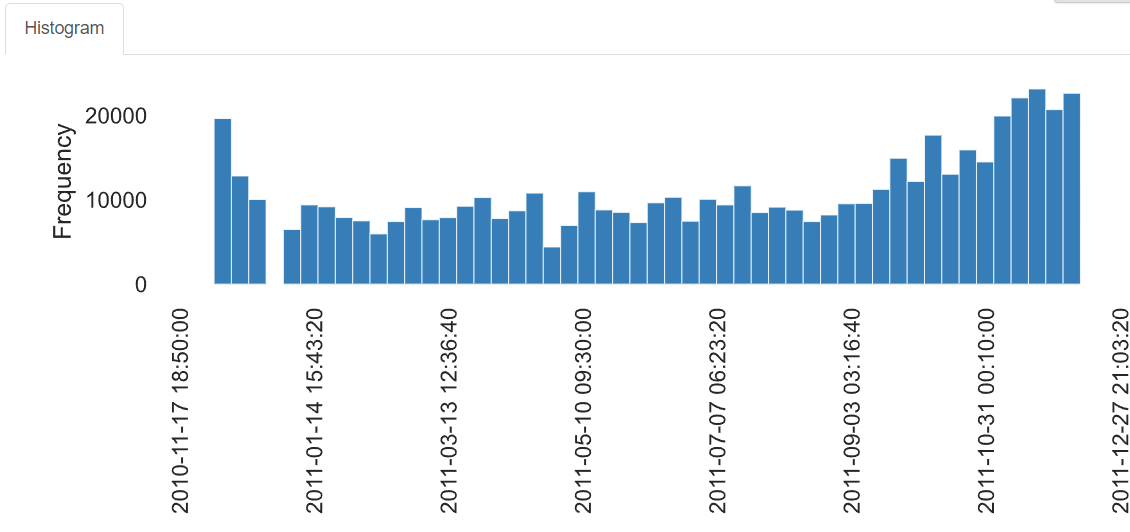

4. <h3>UnitPrice </h3>

   No missing unit price <br>
   However, 0.5% zero unit price and 2 negative unit price. Not sure what zero unit price would mean? <br>
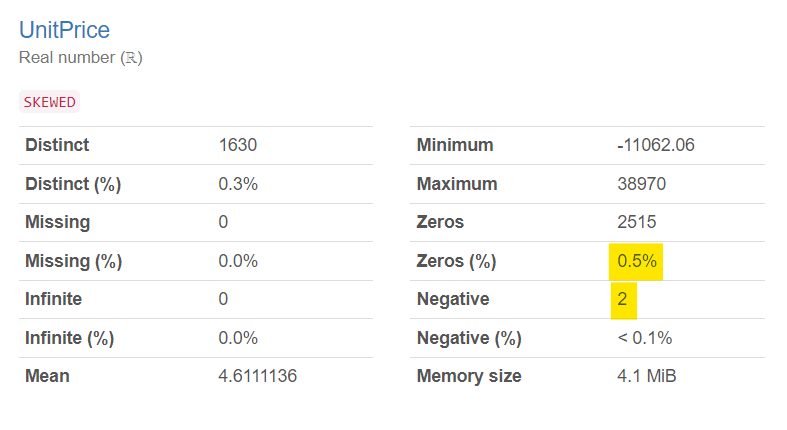

5. <h3>Country</h3>

   No missing data <br>
   United kingdom is predominate country of customers <br>
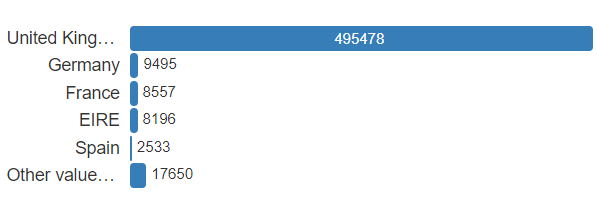

6. <h3>CustomerID</h3>

    <b>25%</b> of customer ids are missing <br>
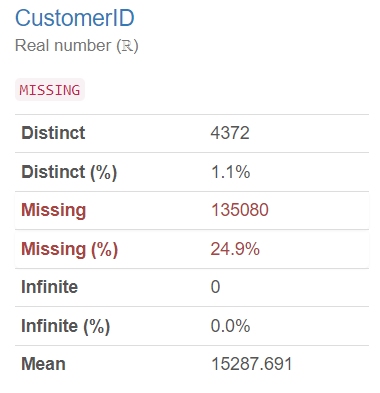

## Handling duplicates
Duplicates rows have identical invoice date and time, indicating it is the same transaction recorded multiple times for reasons unknown. <br>
I'm going to drop the duplicates

In [5]:
raw_data = raw_data.drop_duplicates()

## Removing missing customerid
Records which have no customerid can not be tied to a customer hence such records would be of little use. <br>
I'm going to drop such records

In [6]:
raw_data = raw_data.dropna(subset=['CustomerID'])

### Zero unit prices
Not sure why certain items have unitprice of zero. Either this is an error in record or discount/promotional offers <br>
Either way, knowing about zero unit price products does not help understanding customer behaviour, so i'll drop such records

In [7]:
raw_data[raw_data.UnitPrice==0].head(5)

InvoiceNo StockCode                   Description  Quantity  \
9302     537197     22841  ROUND CAKE TIN VINTAGE GREEN         1   
33576    539263     22580  ADVENT CALENDAR GINGHAM SACK         4   
40089    539722     22423      REGENCY CAKESTAND 3 TIER        10   
47068    540372     22090       PAPER BUNTING RETROSPOT        24   
47070    540372     22553        PLASTERS IN TIN SKULLS        24   

              InvoiceDate  UnitPrice  CustomerID         Country  
9302  2010-12-05 14:02:00        0.0     12647.0         Germany  
33576 2010-12-16 14:36:00        0.0     16560.0  United Kingdom  
40089 2010-12-21 13:45:00        0.0     14911.0            EIRE  
47068 2011-01-06 16:41:00        0.0     13081.0  United Kingdom  
47070 2011-01-06 16:41:00        0.0     13081.0  United Kingdom

In [8]:
raw_data = raw_data[raw_data['UnitPrice'] > 0]

### Feature Engineering 
In order to understand customers better, I'll introduce new customer centric features like total spending, avg spending, cancellation rate etc 

#### days since last purchase

In [9]:
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate'])

# extract invoice date
raw_data['InvoiceDay'] = raw_data['InvoiceDate'].dt.date

# find the most recent purchase date for each customer
customer_data = raw_data.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# find the most recent date in the entire dataset
most_recent_date = raw_data['InvoiceDay'].max()

# convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

### total transactions

In [10]:
# calculate the total number of transactions made by each customer
total_transactions = raw_data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# calculate the total number of products purchased by each customer
total_products_purchased = raw_data.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

#### total spend, avg transaction value and max spending

In [11]:
# calculate the total spend by each customer
raw_data['Total_Spend'] = raw_data['UnitPrice'] * raw_data['Quantity']
total_spend = raw_data.groupby('CustomerID')['Total_Spend'].sum().reset_index()
max_transaction = raw_data.groupby('CustomerID')['Total_Spend'].max().reset_index().rename(columns = {"Total_Spend": "Max_transaction"})

# calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')
customer_data = pd.merge(customer_data, max_transaction, on='CustomerID')

#### unique products purchased

In [12]:
unique_products_purchased = raw_data.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

#### Avg days between purchases, favourite shopping day and hour

In [13]:
raw_data['Day_Of_Week'] = raw_data['InvoiceDate'].dt.dayofweek
raw_data['Hour'] = raw_data['InvoiceDate'].dt.hour

# calculate the average number of days between consecutive purchases
days_between_purchases = raw_data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# find the favorite shopping day of the week
favorite_shopping_day = raw_data.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# find the favorite shopping hour of the day
favorite_shopping_hour = raw_data.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

C:\Users\manpreet\AppData\Local\Temp\ipykernel_3056\2561885293.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = raw_data.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


#### Country info
Since most of the customers (~90%) are from UK, it would make more sense to create a binary feature indicating whether customer is from UK or not.

In [14]:
customer_country_df = raw_data[["CustomerID", "Country"]].drop_duplicates()
customer_country_dict = dict(zip(customer_country_df.CustomerID, customer_country_df.Country))

In [15]:
customer_data["Is_uk"] = customer_data.CustomerID.apply(lambda x: 1 if customer_country_dict[x]=="United Kingdom" else 0)

#### order cancellations

In [16]:
# calculate the total number of transactions made by each customer
total_transactions = raw_data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# calculate the number of cancelled transactions for each customer
cancelled_transactions = raw_data[raw_data['Quantity'] < 0]
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# impute NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# calculate the cancellation rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

C:\Users\manpreet\AppData\Local\Temp\ipykernel_3056\3118456921.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['Cancellation_Frequency'].fillna(0, inplace=True)


#### monthly spending mean and std 

In [17]:
# extract month and year from InvoiceDate
raw_data['Year'] = raw_data['InvoiceDate'].dt.year
raw_data['Month'] = raw_data['InvoiceDate'].dt.month

# calculate monthly spending for each customer
monthly_spending = raw_data.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# calculate Seasonal Buying Patterns: using monthly frequency as a proxy for seasonal buying patterns
spending_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
spending_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
spending_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# # Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, spending_patterns, on='CustomerID')

C:\Users\manpreet\AppData\Local\Temp\ipykernel_3056\4048472296.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spending_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)


### Customer centric dataset is ready!

In [18]:
customer_data.head()

CustomerID  Days_Since_Last_Purchase  Total_Transactions  \
0     12346.0                       325                   2   
1     12347.0                         2                   7   
2     12348.0                        75                   4   
3     12349.0                        18                   1   
4     12350.0                       310                   1   

   Total_Products_Purchased  Total_Spend  Average_Transaction_Value  \
0                         0         0.00                   0.000000   
1                      2458      4310.00                 615.714286   
2                      2341      1797.24                 449.310000   
3                       631      1757.55                1757.550000   
4                       197       334.40                 334.400000   

   Max_transaction  Unique_Products_Purchased  Average_Days_Between_Purchases  \
0          77183.6                          1                        0.000000   
1            249.6                        103                        2.016575   
2            240.0                         22                        9.433333   
3            300.0                         73                        0.000000   
4             40.0                         17                        0.000000   

   Day_Of_Week  Hour  Is_uk  Cancellation_Frequency  Cancellation_Rate  \
0            1    10      1                     1.0                0.5   
1            1    14      0                     0.0                0.0   
2            3    19      0                     0.0                0.0   
3            0     9      0                     0.0                0.0   
4            2    16      0                     0.0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  
0               0.000000              0.000000  
1             615.714286            341.070789  
2             449.310000            301.159918  
3            1757.550000              0.000000  
4             334.400000              0.000000

### Removing outliers using IsolationForest
more info - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [19]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['outlier_scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['is_outlier'] = [1 if x == -1 else 0 for x in customer_data['outlier_scores']]

In [20]:
customer_data.groupby("is_outlier").count()["Total_Spend"]*100/len(customer_data)

is_outlier
0    94.991847
1     5.008153
Name: Total_Spend, dtype: float64

### Check for correlating features

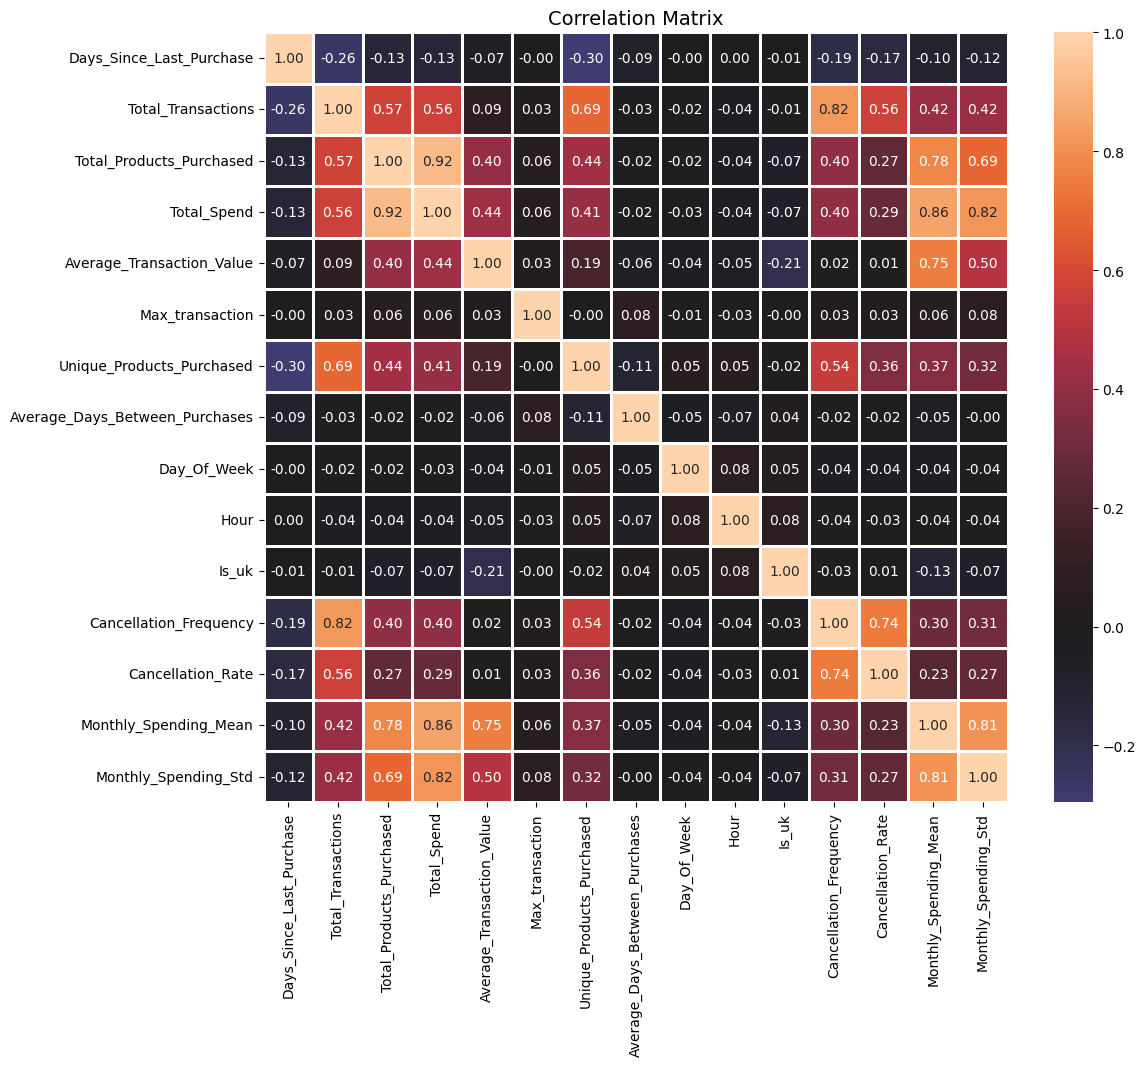

In [21]:
%matplotlib inline
corr = customer_data.drop(columns=['CustomerID', 'is_outlier', 'outlier_scores']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

##### Following pair of variables have high correlations, indicating multicollinearity
Total transactions and cancellation freq <br>
Total spend and total product purchased <br>
total spend and monthly spend <br>
<b>Hence I'll drop Total spend and cancellation freq</b>

In [22]:
customer_data = customer_data.drop(columns=["Total_Spend", "Cancellation_Frequency"])

### Scaling
Since kmeans uses euclidean distance, it is sensitive to scale of data, hence will be scaling the data

In [23]:
customer_data = customer_data[customer_data.is_outlier == 0]

In [24]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_uk', 'Day_Of_Week',  'is_outlier', 'outlier_scores']

# List of columns that need to be scaled
columns_to_scale = customer_data.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

### Apply PCA to denoise the data

Text(0.5, 1.0, 'Cumulative Variance vs. Number of Components')

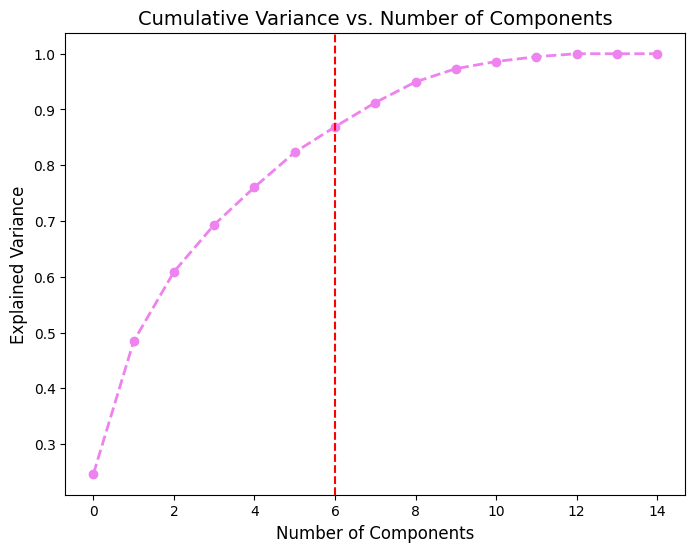

In [25]:
# # setting sustomerID as the index
customer_data_scaled.set_index('CustomerID', inplace=True)

# apply PCA
pca = PCA().fit(customer_data_scaled)

# calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))

# line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='violet', linewidth=2)

# plot optimal component
optimal_k_line = plt.axvline(7- 1, color='red', linestyle='--', label=f'Optimal k value = {6}') 

plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)
plt.title('Cumulative Variance vs. Number of Components', fontsize=14)

In [26]:
# Creating a PCA object with 7 components
pca = PCA(n_components=7)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

### Clustering using kmeans

In [27]:
wcss = [] 
for i in range(1, 20): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(customer_data_pca) 
    wcss.append(kmeans.inertia_)

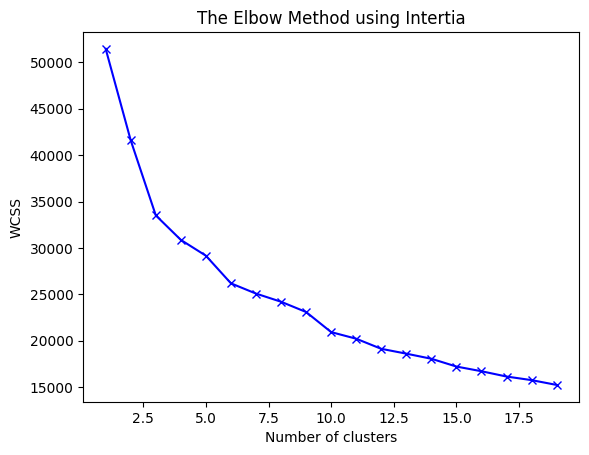

In [29]:
%matplotlib inline
plt.plot(list(range(1,20)), wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('The Elbow Method using Intertia')
plt.show()

##### Using the elbow method, 3 seems like a reasonable cluster number

In [30]:
no_of_clusters = 3

#### Applying kmeans with k=3

In [31]:
kmeans = KMeans(n_clusters = no_of_clusters, init = 'k-means++', random_state = 24)
kmeans.fit(customer_data_pca)
customer_data_pca["cluster"]=kmeans.predict(customer_data_pca)

In [32]:
customer_data_pca["CustomerID"] = customer_data_pca.index
customer_cluster_mapping = dict(zip(customer_data_pca.CustomerID, customer_data_pca.cluster))

In [33]:
customer_data["cluster"] = customer_data.apply(lambda x: customer_cluster_mapping[x.CustomerID], axis=1)

### Glance at mean of the clusters

In [34]:
customer_data.drop(columns=["CustomerID", "is_outlier", "outlier_scores"]).groupby(['cluster'], as_index=False).mean()

cluster  Days_Since_Last_Purchase  Total_Transactions  \
0        0                106.077529            2.783162   
1        1                 37.670171            9.277267   
2        2                103.684874            2.797719   

   Total_Products_Purchased  Average_Transaction_Value  Max_transaction  \
0                373.374924                 249.661540        63.323113   
1               1878.632063                 448.098420       173.774612   
2                376.046218                 250.245172        68.511759   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                  41.543307                        2.988936     4.190793   
1                 121.764783                        2.354218     2.398160   
2                  36.699880                        4.085819     0.991597   

        Hour     Is_uk  Cancellation_Rate  Monthly_Spending_Mean  \
0  12.741369  0.921866           0.148788             293.669090   
1  12.346912  0.886991           0.833292             653.124632   
2  12.350540  0.910564           0.167635             289.313567   

   Monthly_Spending_Std  
0             75.001931  
1            354.765316  
2             73.146565

##### To have better idea about each cluster (and not just mean), I'll standardize the data and create radar plots

In [35]:
scaler = StandardScaler()
customer_data_standardized = scaler.fit_transform(customer_data.drop(columns=['cluster'], axis=1))

In [36]:
df_customer_standardized = pd.DataFrame(customer_data_standardized, columns=customer_data.columns[:-1], index=customer_data.index)
df_customer_standardized['cluster'] = customer_data['cluster']

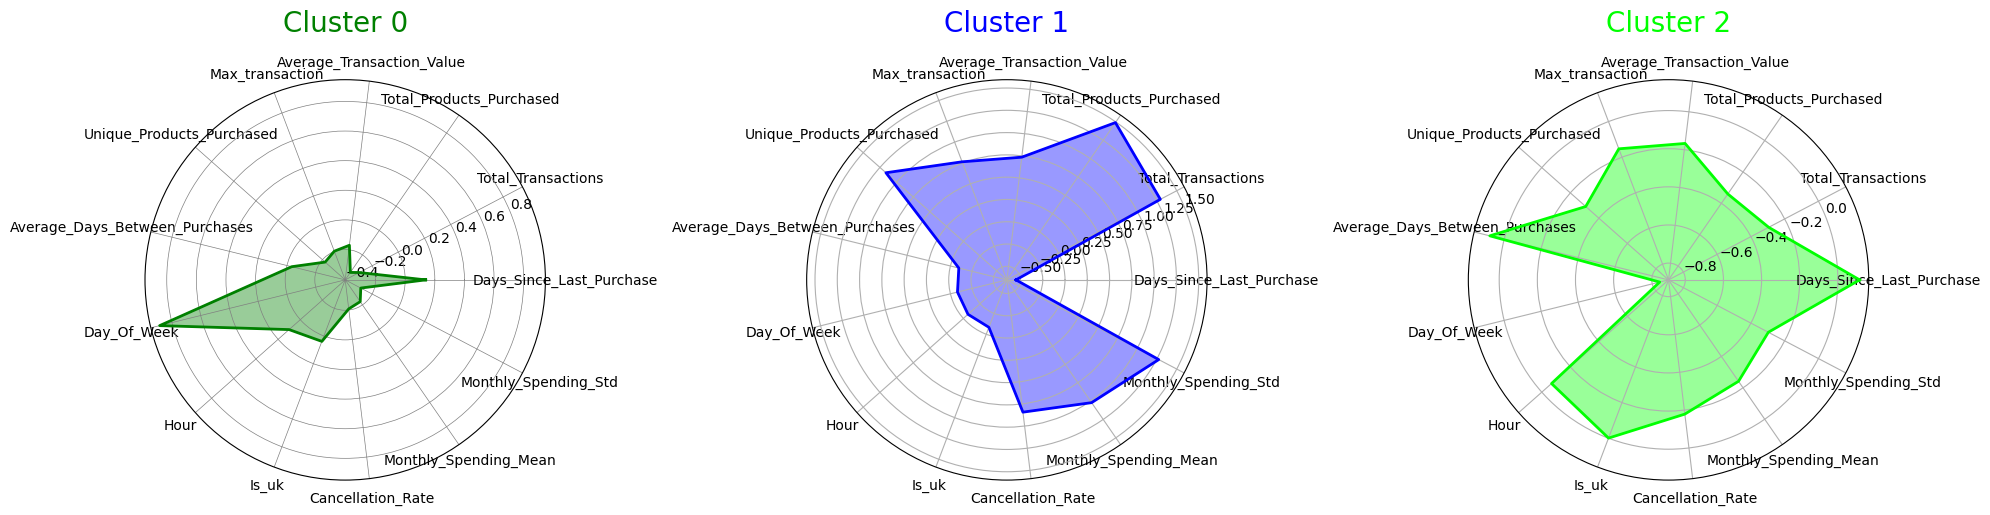

In [38]:
# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.drop(columns=['CustomerID', 'is_outlier', 'outlier_scores']).groupby('cluster').mean()
# cluster_centroids = customer_data.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=no_of_clusters)

# Create radar chart for each cluster
colors = ['green', 'blue', 'lime']
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

### Visulizing individual clusters with histogram

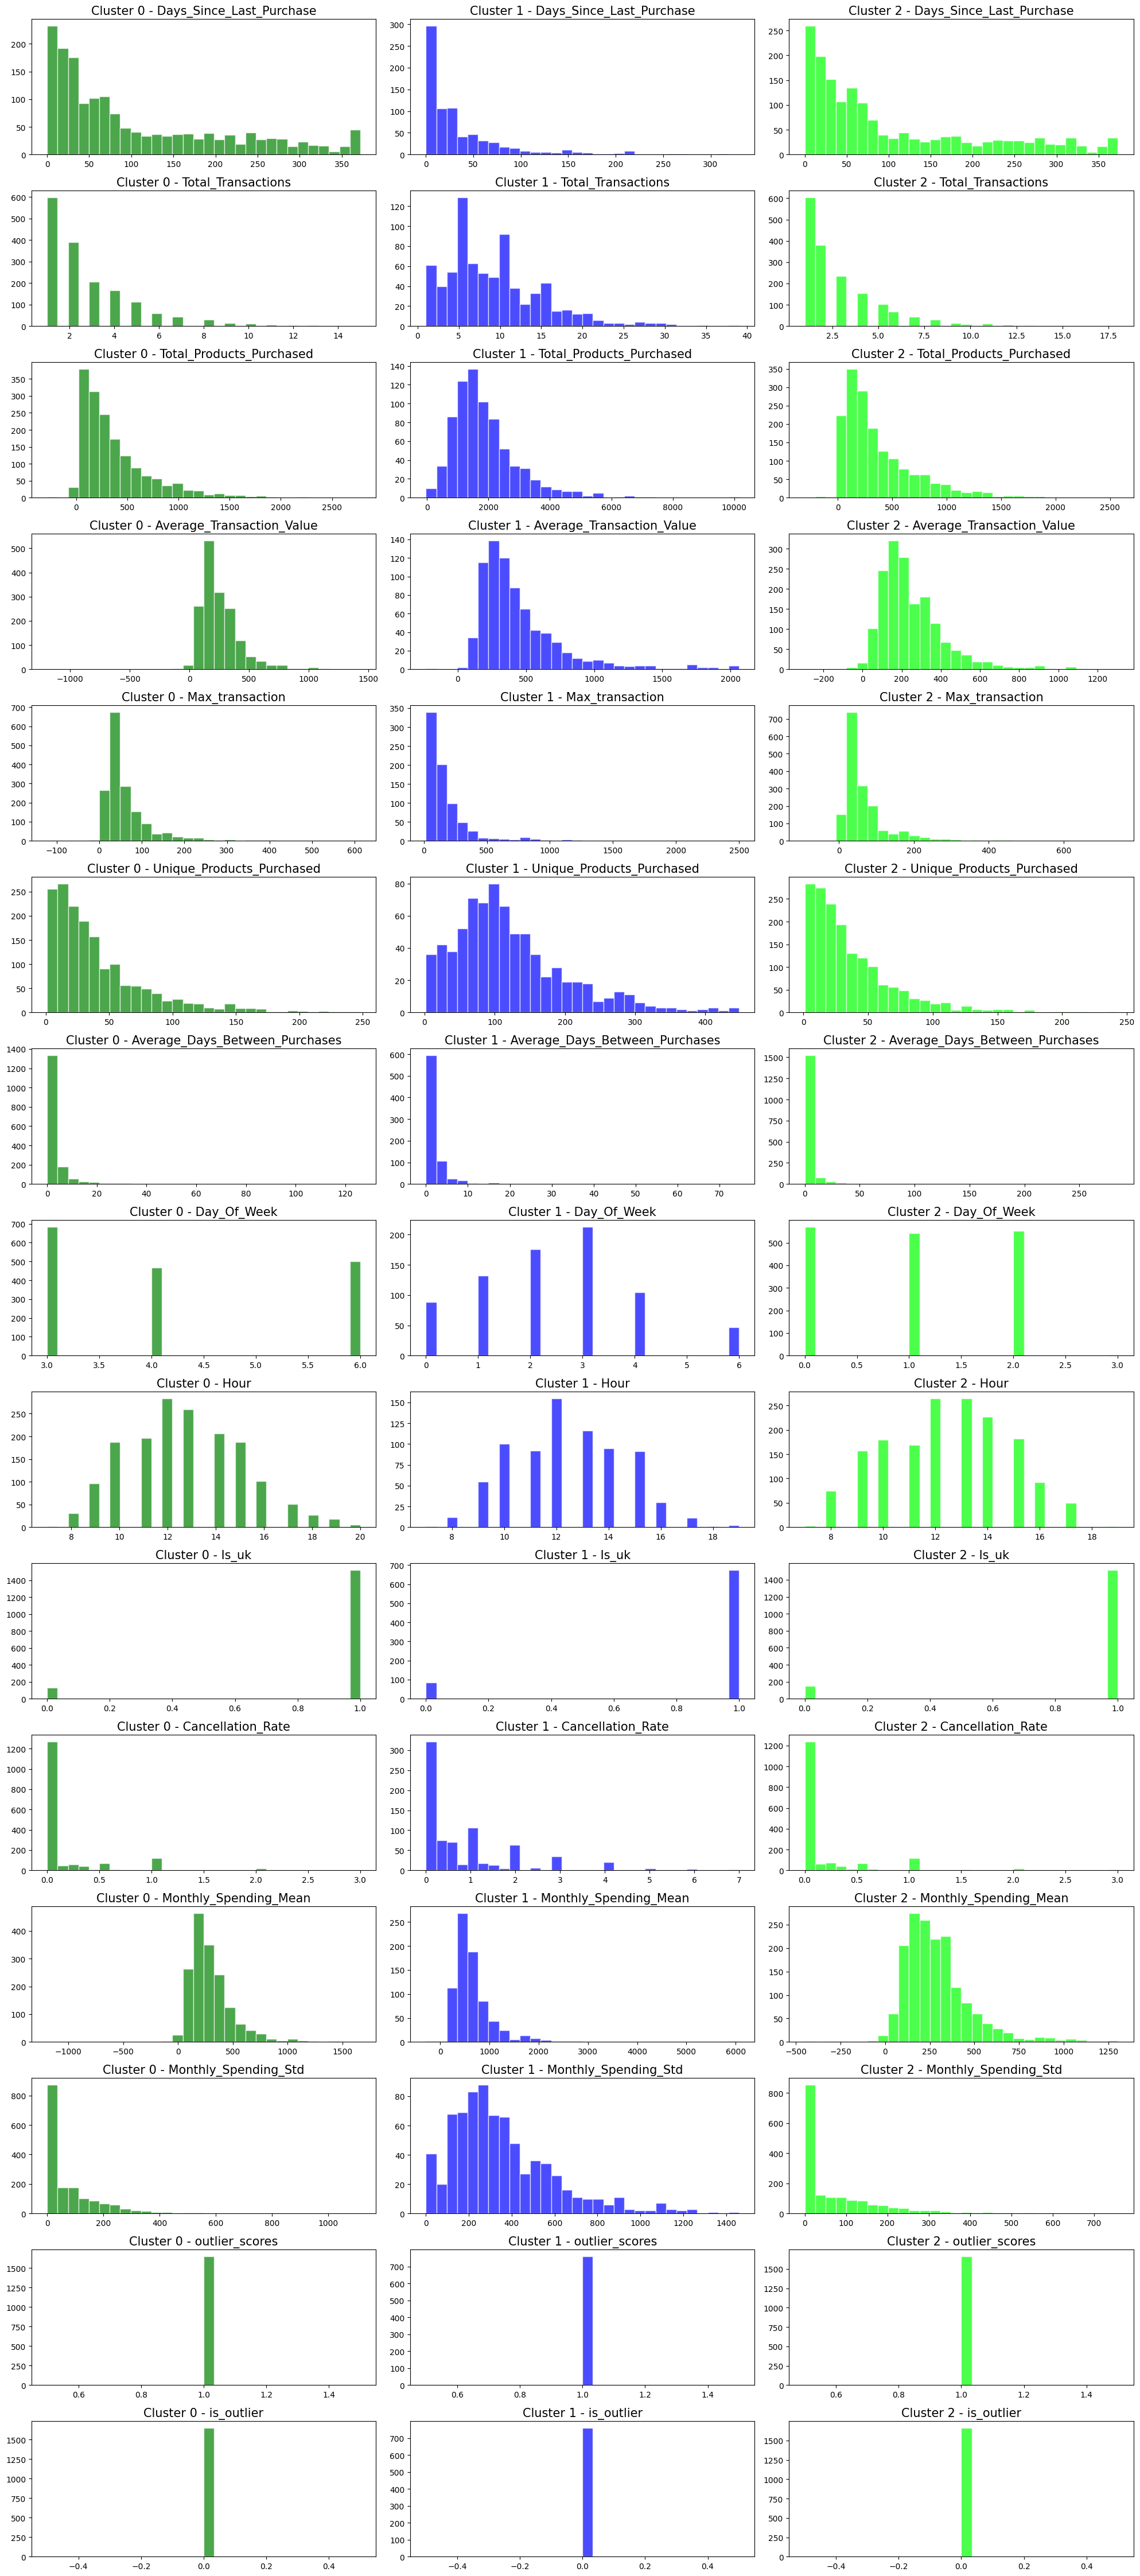

In [39]:
# Plot histograms for each feature segmented by the clusters
features = customer_data.columns[1:-1]
clusters = customer_data['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, no_of_clusters*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data[customer_data['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=30, edgecolor='w', alpha=0.7, color=colors[j])
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

# Conclusion


Using unsupervised learning (kmeans), I could identify 3 clusters of customer types using customer centrics metrics. Based on each cluster property, I'll try to define characterstics of each cluster, on basis of which further marketing strategies can be made.

1. Cluster 0 - Low-volume, Low-spend weekend purchasers
   - Customers in this cluster purchase less frequently and spend less money
   - Most of the purchases happen near the weekend (Thursday, friday, sunday)
   - cancellation rates are lower <br>
    
2. Cluster 1 - High spending volatile purchasers
   - Customers in this cluster buy frequently and spend high money
   - they purchase variety of products
   - actively purchases throughout the week
   - cancellation rate is bit high
   - their spending has lot of flucutations <br>
  
3. Cluster 2 - Low-volume, Low-spend weekday purchasers
   - Customers in this cluster purchase less frequently and spend least amount of money
   - mostly purchases starting of weekday (monday, tuesday, wednesday)
   - cancellation rates are low
   